### Multi-Class Model for Crop Mapping with Fused Optical and Radar Data Using Python and Scikit-Learn
### David Lowe
### December 27, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Crop Mapping with Fused Optical Radar Data dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset combines optical and PolSAR remote sensing images for cropland classification. The organization collected the images using RapidEye satellites (optical) and the Unmanned Aerial Vehicle Synthetic Aperture Radar (UAVSAR) system (radar) over an agricultural region near Winnipeg, Manitoba, Canada, in 2012. There are two sets of 49-radar features and two sets of 38-optical features for 05 and 14 July 2012. Seven crop type classes exist for this data set: 1-Corn; 2-Peas; 3-Canola; 4-Soybeans; 5-Oats; 6-Wheat; and 7-Broadleaf.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 0.9908 using the training dataset. Furthermore, we selected Extra Trees as the final model as it processed the training dataset with a final accuracy score of 0.9975. When we processed the test dataset with the final model, the model achieved an accuracy score of 0.9976.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Crop Mapping with Fused Optical Radar Data

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/crop+mapping+using+fused+optical+radar+data+set

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 88

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [5]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'WinnipegDataset.txt'
# TEST_DATASET = 'test.csv'

In [6]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/crop-mapping-winnipeg/WinnipegDataset.txt

In [9]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   label      f1      f2       f3      f4      f5      f6      f7      f8  \
0      1 -13.559 -21.407 -11.4040 -15.248 -11.923 -15.291 -2.1548 -7.8474   
1      1 -12.802 -20.335 -10.3990 -14.132 -11.096 -14.361 -2.4039 -7.5330   
2      1 -12.431 -19.902 -10.0740 -13.598 -10.829 -14.048 -2.3566 -7.4717   
3      1 -12.689 -19.529 -10.0280 -13.350 -11.056 -14.014 -2.6611 -6.8396   
4      1 -12.686 -19.278  -9.8185 -13.108 -10.932 -13.939 -2.8675 -6.5919   

        f9  ...     f165     f166    f167      f168     f169     f170  \
0 -10.0020  ...  0.18519  0.72602  5.3333  6.000000  0.29489  9.77780   
1  -9.9369  ...  0.33333 -0.48751  2.1111  0.098765  0.83333  0.33333   
2  -9.8283  ...  0.25926  0.25298  2.2222  0.172840  0.68889  0.88889   
3  -9.5006  ...  0.16049  0.43750  4.1111  0.320990  0.83333  0.33333   
4  -9.4594  ...  0.18519  0.35000  4.0000  0.444440  0.68889  0.88889   

      f171     f172     f173     f174  
0  2.44440  1.67700  0.20988  0.65422  
1  0.33333  0.8486

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #    Column  Dtype  
---   ------  -----  
 0    label   int64  
 1    f1      float64
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     float64
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     float64
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     float64
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f3

In [11]:
print(df_dataset_import.describe())

               label             f1             f2             f3  \
count  325834.000000  325834.000000  325834.000000  325834.000000   
mean        4.062421     -15.143602     -24.026035     -15.400034   
std         1.604617       3.504255       4.054214       3.267857   
min         1.000000     -23.971000     -34.308000     -23.161000   
25%         3.000000     -17.848000     -27.119000     -17.563000   
50%         4.000000     -15.992000     -25.064000     -16.164000   
75%         6.000000     -11.786000     -20.387000     -13.427000   
max         7.000000       2.535600      -7.589100       1.104000   

                 f4             f5             f6             f7  \
count  325834.00000  325834.000000  325834.000000  325834.000000   
mean      -18.59383     -14.493472     -18.427329       0.256432   
std         3.71163       3.189013       3.675741       1.682060   
min       -27.24500     -22.103000     -26.897000      -5.582600   
25%       -21.44900     -16.989000    

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

label    0
f1       0
f2       0
f3       0
f4       0
        ..
f170     0
f171     0
f172     0
f173     0
f174     0
Length: 175, dtype: int64
Total number of NaN in the dataframe:  0


In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('label').size())

label
1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'label':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   target      f1      f2       f3      f4      f5      f6      f7      f8  \
0       1 -13.559 -21.407 -11.4040 -15.248 -11.923 -15.291 -2.1548 -7.8474   
1       1 -12.802 -20.335 -10.3990 -14.132 -11.096 -14.361 -2.4039 -7.5330   
2       1 -12.431 -19.902 -10.0740 -13.598 -10.829 -14.048 -2.3566 -7.4717   
3       1 -12.689 -19.529 -10.0280 -13.350 -11.056 -14.014 -2.6611 -6.8396   
4       1 -12.686 -19.278  -9.8185 -13.108 -10.932 -13.939 -2.8675 -6.5919   

        f9  ...     f165     f166    f167      f168     f169     f170  \
0 -10.0020  ...  0.18519  0.72602  5.3333  6.000000  0.29489  9.77780   
1  -9.9369  ...  0.33333 -0.48751  2.1111  0.098765  0.83333  0.33333   
2  -9.8283  ...  0.25926  0.25298  2.2222  0.172840  0.68889  0.88889   
3  -9.5006  ...  0.16049  0.43750  4.1111  0.320990  0.83333  0.33333   
4  -9.4594  ...  0.18519  0.35000  4.0000  0.444440  0.68889  0.88889   

      f171     f172     f173     f174  
0  2.44440  1.67700  0.20988  0.65422  
1  0.33333  

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #    Column  Dtype  
---   ------  -----  
 0    target  int64  
 1    f1      float64
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     float64
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     float64
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     float64
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f3

In [16]:
print(df_dataset_import.describe())

              target             f1             f2             f3  \
count  325834.000000  325834.000000  325834.000000  325834.000000   
mean        4.062421     -15.143602     -24.026035     -15.400034   
std         1.604617       3.504255       4.054214       3.267857   
min         1.000000     -23.971000     -34.308000     -23.161000   
25%         3.000000     -17.848000     -27.119000     -17.563000   
50%         4.000000     -15.992000     -25.064000     -16.164000   
75%         6.000000     -11.786000     -20.387000     -13.427000   
max         7.000000       2.535600      -7.589100       1.104000   

                 f4             f5             f6             f7  \
count  325834.00000  325834.000000  325834.000000  325834.000000   
mean      -18.59383     -14.493472     -18.427329       0.256432   
std         3.71163       3.189013       3.675741       1.682060   
min       -27.24500     -22.103000     -26.897000      -5.582600   
25%       -21.44900     -16.989000    

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

target    0
f1        0
f2        0
f3        0
f4        0
         ..
f170      0
f171      0
f172      0
f173      0
f174      0
Length: 175, dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (325834, 175) df_features_import.shape: (325834, 174) df_target_import.shape: (325834,)


In [20]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (293250, 174) df_target_train.shape: (293250,)
df_features_test.shape: (32584, 174) df_target_test.shape: (32584,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

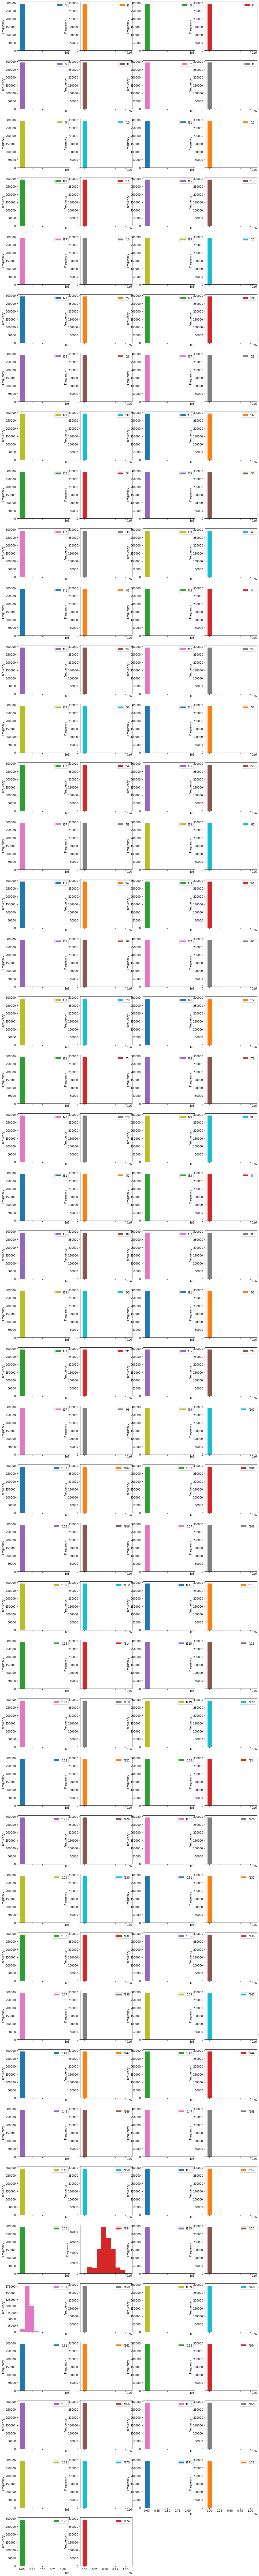

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

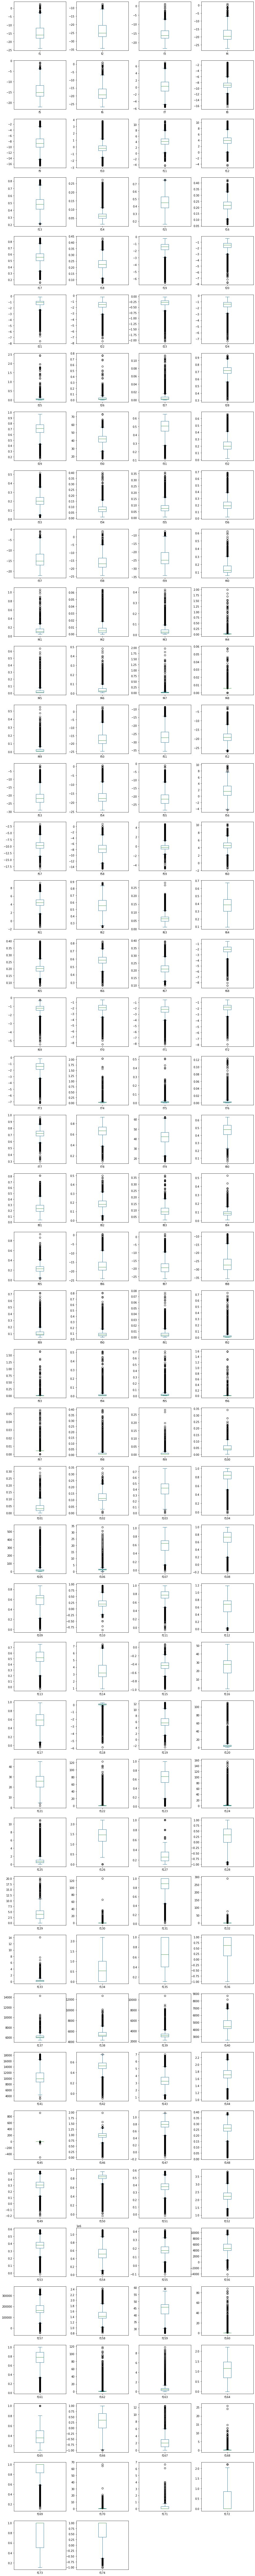

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [26]:
# # Correlation matrix
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)
# correlations = df_features_train.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 174
Number of categorical columns: 0
Total number of columns in the feature dataframe: 174


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (293250, 174) to array_features_train.shape: (293250, 174)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (293250, 174) array_target_train.shape: (293250,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [37]:
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS, solver='saga')))
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
# train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [38]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm " + name + " modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm " + name + " modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pythonml/appdev/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LGR: 0.986684 (0.000552)
LogisticRegression(n_jobs=2, random_state=88, solver='saga')
Model training time: 0:29:45.577016 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LDA: 0.982609 (0.000470)
LinearDiscriminantAnalysis()
Model training time: 0:01:04.878367 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.988709 (0.000420)
DecisionTreeClassifier(random_state=88)
Model training time: 0:10:35.190142 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 35.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.993245 (0.000206)
BaggingClassifier(n_jobs=2, random_state=88)
Model training time: 0:35:27.460429 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 24.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.996310 (0.000276)
RandomForestClassifier(n_jobs=2, random_state=88)
Model training time: 0:24:29.187415 

EXT: 0.997333 (0.000221)
ExtraTreesClassifier(n_jobs=2, random_state=88)
Model training time: 0:03:33.677416 

Average metrics (accuracy) from all models: 0.9908150042625747
Total training time for all models: 1:44:56.015334


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.6min finished


### 4.b) Spot-checking baseline algorithms

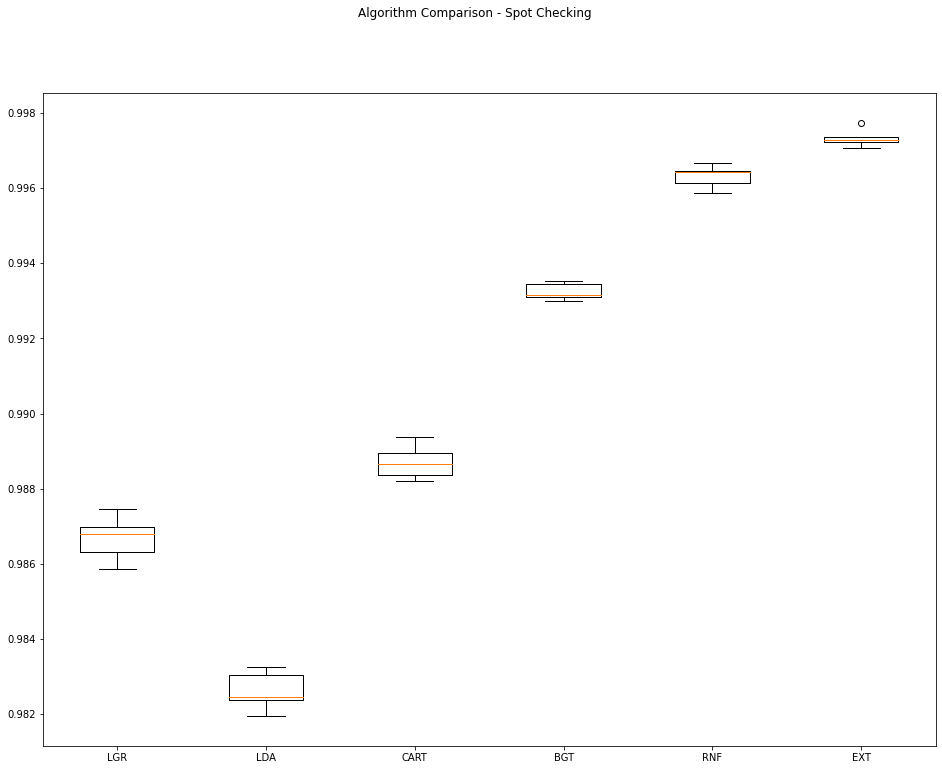

In [39]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

### 4.c) Algorithm Tuning

In [40]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [41]:
# Tuning algorithm #1 - Extra Trees
start_time_mudule = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_mudule))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.997535 using {'n_estimators': 500}
0.997333 (0.000221) with: {'n_estimators': 100}
0.997494 (0.000209) with: {'n_estimators': 300}
0.997535 (0.000221) with: {'n_estimators': 500}
Model training time: 0:34:32.715390


In [42]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 500


In [43]:
# Tuning algorithm #2 - Random Forest
start_time_mudule = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_mudule))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.996454 using {'n_estimators': 500}
0.996310 (0.000276) with: {'n_estimators': 100}
0.996406 (0.000269) with: {'n_estimators': 300}
0.996454 (0.000233) with: {'n_estimators': 500}
Model training time: 4:09:45.490138


In [44]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 4.d) Compare Algorithms After Tuning

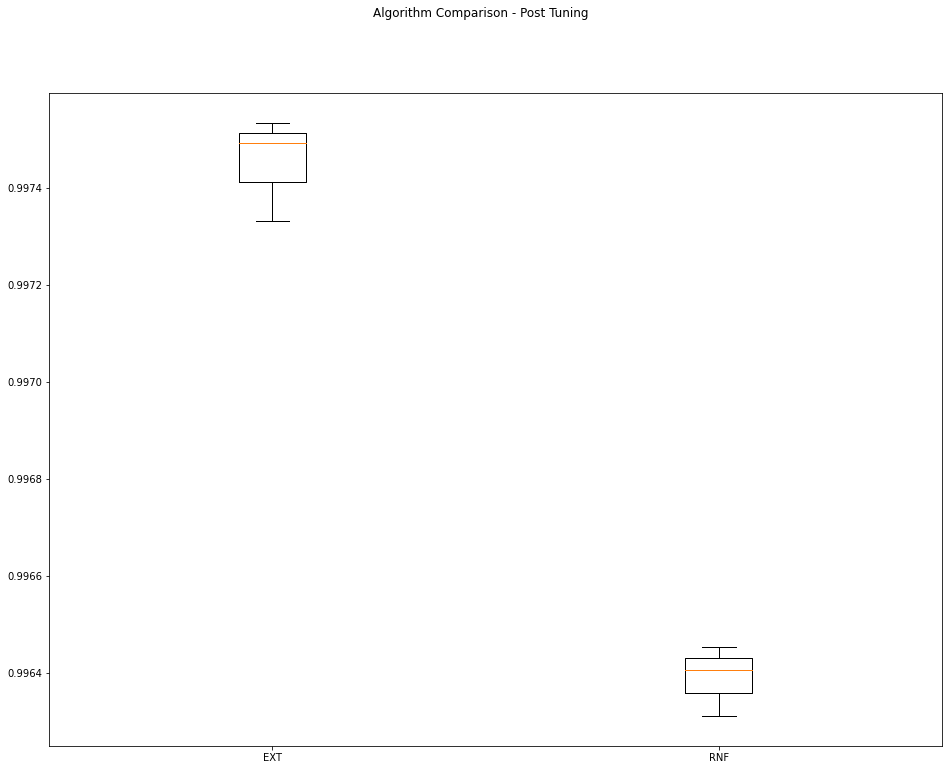

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [48]:
final_model = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

ExtraTreesClassifier(n_estimators=500, n_jobs=2, random_state=88)


### 5.b) Load Test Dataset and Make Predictions

In [49]:
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
# array_target_test = label_encoder.transform(df_target_test)
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (32584, 174) array_target_test.shape: (32584,)


In [50]:
# Make batched predictions
# test_predictions = label_encoder.inverse_transform(final_model.predict(array_features_test))
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[1 1 4 ... 6 6 5]


In [51]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9976982568131598 

[[3926    0    0    0    1    0    4]
 [   1  361    0    1    0    0    0]
 [   0    0 7466    2    1    0    0]
 [   2    0    2 7438    8    1    0]
 [   2    0    0   13 4730   16    1]
 [   0    0    1    9    8 8466    0]
 [   1    0    0    0    0    1  122]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3931
           2       1.00      0.99      1.00       363
           3       1.00      1.00      1.00      7469
           4       1.00      1.00      1.00      7451
           5       1.00      0.99      0.99      4762
           6       1.00      1.00      1.00      8484
           7       0.96      0.98      0.97       124

    accuracy                           1.00     32584
   macro avg       0.99      1.00      0.99     32584
weighted avg       1.00      1.00      1.00     32584



In [52]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 6:38:46.364955
